In [3]:
import pandas as pd 
customers= pd.read_excel(r"C:\Users\GSI\Desktop\DataWareHouse\Customers_f.xlsx")
orders = pd.read_excel (r"C:\Users\GSI\Desktop\DataWareHouse\orders.xlsx") 
products = pd.read_excel(r"C:\Users\GSI\Desktop\DataWareHouse\Products_f.xlsx")
sales = pd.read_excel(r"C:\Users\GSI\Desktop\DataWareHouse\Sales.xlsx")

In [4]:
print(sales.columns)
print(orders.columns)
print(customers.columns)

Index(['code_sale', 'code_customer', 'code_order', 'SKU', 'code_ship_type',
       'code_pricing_strategy', 'code_payment_method', 'quantity', 'prod_name',
       'Estimated_Unit_Price', 'sale_date', 'is_discounted'],
      dtype='object')
Index(['order_code', 'status_label', 'reason'], dtype='object')
Index(['code_customer', 'Age', 'Gender', 'Zip_code', 'Preferred_size',
       'Overall_review', 'Subscription Status', 'Previous Purchases',
       'Payment Method', 'Frequency of Purchases'],
      dtype='object')


LinearRegression - R²: 0.1613, MSE: 0.000001
Ridge - R²: 0.1613, MSE: 0.000001
Lasso - R²: 0.1613, MSE: 0.000001
DecisionTree - R²: 1.0000, MSE: 0.000000
RandomForest - R²: 0.8106, MSE: 0.000000
Polynomial (deg=2) - R²: 0.6713, MSE: 0.000000


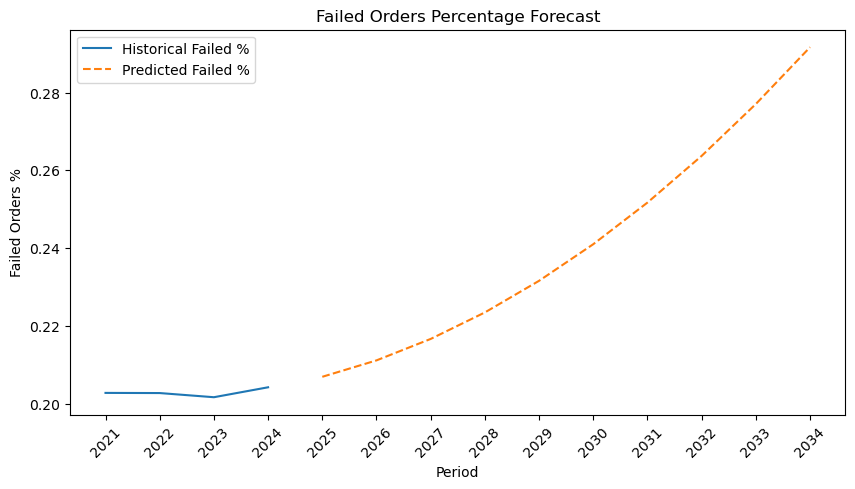

   period                 reason  pred_failed_pct  pred_reason_pct  \
0    2025  Customer changed mind         0.206912         0.158461   
1    2025           Damaged item         0.206912         0.167659   
2    2025          Late delivery         0.206912         0.208152   
3    2025           Out of stock         0.206912         0.256614   
4    2025        Wrong item sent         0.206912         0.209115   
5    2026  Customer changed mind         0.211132         0.158461   
6    2026           Damaged item         0.211132         0.167659   
7    2026          Late delivery         0.211132         0.208152   
8    2026           Out of stock         0.211132         0.256614   
9    2026        Wrong item sent         0.211132         0.209115   
10   2027  Customer changed mind         0.216649         0.158461   
11   2027           Damaged item         0.216649         0.167659   
12   2027          Late delivery         0.216649         0.208152   
13   2027           

In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


# ==========================
# 1) Merge and filter data
# ==========================
df = sales.merge(orders, left_on="code_order", right_on="order_code", how="left")
# Convert dates
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Add failed flag (Returned or Cancelled)
df['is_failed'] = df['status_label'].isin(['Returned', 'Cancelled']).astype(int)

# Fill delivered or others with 'No Issue' reason
df['reason'] = df['reason'].fillna('No Issue')

# ==========================
# 2) Aggregate total orders and failed orders per year fi3oudh chhar
# ==========================
df['period'] = df['sale_date'].dt.to_period('Y')

# Total orders and failed orders per year
agg_total = df.groupby('period').agg(
    total_orders=('status_label', 'count'),
    failed_orders=('is_failed', 'sum')
).reset_index()

agg_total['failed_pct'] = agg_total['failed_orders'] / agg_total['total_orders']

# ==========================
# 3) Aggregate failed orders by reason per year
# ==========================
failed_df = df[df['is_failed'] == 1]

agg_reason = failed_df.groupby(['period','reason']).agg(
    failed_orders=('is_failed', 'sum')
).reset_index()

# Merge to get total failed orders per year
agg_reason = agg_reason.merge(agg_total[['period','failed_orders']], on='period', suffixes=('_reason','_total'))

# Percentage of each reason among failed orders
agg_reason['reason_pct'] = agg_reason['failed_orders_reason'] / agg_reason['failed_orders_total']

# ==========================
# 4) Predict future failed orders % using Linear Regression
# ==========================
# Convert period to numeric for regression
agg_total['period_num'] = agg_total['period'].apply(lambda x: x.to_timestamp().timestamp())

X = agg_total[['period_num']]
y = agg_total['failed_pct']

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=0.5),
    "Lasso": Lasso(alpha=0.01),
    "DecisionTree": DecisionTreeRegressor(max_depth=3),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
    "Polynomial (deg=2)": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('lin', LinearRegression())
    ])
}
for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print(f"{name} - R²: {r2:.4f}, MSE: {mse:.6f}")


# Predict next 10 years
last_period = agg_total['period'].max()
future_periods = pd.period_range(start=last_period + 1, periods=10, freq='Y')

future_df = pd.DataFrame({'period': future_periods})
future_df['period_num'] = future_df['period'].apply(lambda x: x.to_timestamp().timestamp())
future_df['pred_failed_pct'] = model.predict(future_df[['period_num']])

# ==========================
# 5) Predict future reason distribution
# ==========================
# Use average historical reason distribution
reason_dist = agg_reason.groupby('reason')['reason_pct'].mean().reset_index()

all_predictions = []

for i, row in future_df.iterrows():
    for _, r in reason_dist.iterrows():
        all_predictions.append({
            'period': row['period'],
            'reason': r['reason'],
            'pred_failed_pct': row['pred_failed_pct'],
            'pred_reason_pct': r['reason_pct'],
            'pred_failed_orders_pct': row['pred_failed_pct'] * r['reason_pct']
        })

pred_df = pd.DataFrame(all_predictions)

# ==========================
# 6) Optional: Visualize
# ==========================

plt.figure(figsize=(10,5))
plt.plot(agg_total['period'].astype(str), agg_total['failed_pct'], label='Historical Failed %')
plt.plot(future_df['period'].astype(str), future_df['pred_failed_pct'], label='Predicted Failed %', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Period')
plt.ylabel('Failed Orders %')
plt.title('Failed Orders Percentage Forecast')
plt.legend()
plt.show()


# ==========================
# 7) Display predictions
# ==========================
print(pred_df.head(20))




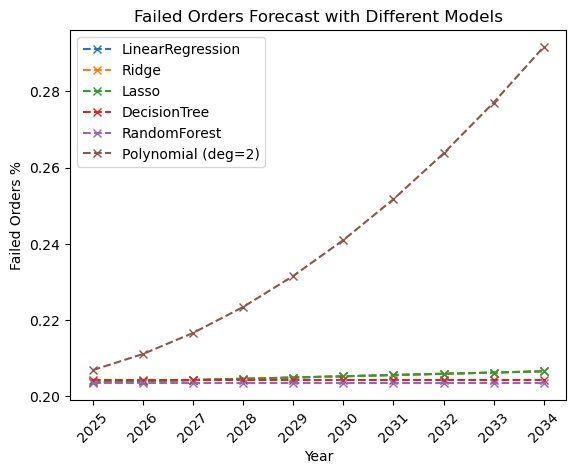

In [6]:
future_preds = pd.DataFrame({'period': future_df['period']})

for name, model in models.items():
    future_preds[name] = model.predict(future_df[['period_num']])

for name in models.keys():
    plt.plot(future_preds['period'].astype(str), future_preds[name], label=name, linestyle='--', marker='x')

plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Failed Orders %')
plt.title('Failed Orders Forecast with Different Models')
plt.legend()
plt.show()

In [7]:
# Add year
pred_df['year'] = pred_df['period'].dt.year

# Aggregate predicted failed orders per reason per year
year_reason_failed = pred_df.groupby(['year', 'reason'])['pred_failed_orders_pct'].sum().reset_index()

# Total predicted failed orders per year
year_total_failed = year_reason_failed.groupby('year')['pred_failed_orders_pct'].sum().reset_index(name='total_failed_pct')

# Merge and normalize per year
year_reason_failed = year_reason_failed.merge(year_total_failed, on='year')
year_reason_failed['reason_fraction'] = year_reason_failed['pred_failed_orders_pct'] / year_reason_failed['total_failed_pct']

# Pivot table for clarity
year_reason_pivot = year_reason_failed.pivot(index='year', columns='reason', values='reason_fraction').fillna(0)

# Add total failed %
year_reason_pivot['total_failed_pct'] = year_total_failed['total_failed_pct'].values

print(year_reason_pivot)


reason  Customer changed mind  Damaged item  Late delivery  Out of stock  \
year                                                                       
2025                 0.158461      0.167659       0.208152      0.256614   
2026                 0.158461      0.167659       0.208152      0.256614   
2027                 0.158461      0.167659       0.208152      0.256614   
2028                 0.158461      0.167659       0.208152      0.256614   
2029                 0.158461      0.167659       0.208152      0.256614   
2030                 0.158461      0.167659       0.208152      0.256614   
2031                 0.158461      0.167659       0.208152      0.256614   
2032                 0.158461      0.167659       0.208152      0.256614   
2033                 0.158461      0.167659       0.208152      0.256614   
2034                 0.158461      0.167659       0.208152      0.256614   

reason  Wrong item sent  total_failed_pct  
year                                       

In [ ]:
# Sauvegarder le modèle Polynomial (meilleur modèle sélectionné)
import joblib

# Entraîner le modèle Polynomial (degree=2)
best_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lin', LinearRegression())
])
best_model.fit(X, y)

# Sauvegarder le modèle Polynomial
joblib.dump(best_model, 'regression_failed_orders_pct.pkl')
print("Modèle Polynomial sauvegardé : regression_failed_orders_pct.pkl")

# Aucun scaler n'est utilisé (pas de standardisation)
print("Aucun scaler à sauvegarder (pas de standardisation appliquée).")

# Aucun encodeur n'est utilisé (features numériques uniquement)
print("Aucun encodeur à sauvegarder (features numériques uniquement).")

print("\nModèle Polynomial sélectionné et sauvegardé avec succès !")

Modèle sauvegardé : regression_failed_orders_pct.pkl
Aucun scaler à sauvegarder (pas de standardisation appliquée).
Aucun encodeur à sauvegarder (features numériques uniquement).

Tous les fichiers .pkl ont été sauvegardés avec succès !


In [ ]:
# Sauvegarder le modèle Polynomial (meilleur modèle sélectionné)
import joblib

# Entraîner le modèle Polynomial (degree=2)
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lin', LinearRegression())
])
poly_model.fit(X, y)

# Sauvegarder le modèle Polynomial
joblib.dump(poly_model, 'regression_failed_orders_pct.pkl')
print("Modèle Polynomial sauvegardé : regression_failed_orders_pct.pkl")

# Aucun scaler n'est utilisé (pas de standardisation)
print("Aucun scaler à sauvegarder (pas de standardisation appliquée).")

# Aucun encodeur n'est utilisé (features numériques uniquement)
print("Aucun encodeur à sauvegarder (features numériques uniquement).")

print("\nModèle Polynomial sélectionné et sauvegardé avec succès !")

In [9]:
# Test du modèle sauvegardé
import joblib
import pandas as pd
import numpy as np

# Charger le modèle
model = joblib.load('regression_failed_orders_pct.pkl')
print("Modèle chargé avec succès!")
print(f"Type du modèle: {type(model)}")

# Données de test : périodes futures
# Créer des périodes de test (années futures)
test_years = [2025, 2026, 2027, 2028, 2029, 2030]
test_data = []

for year in test_years:
    # Convertir l'année en timestamp (comme dans le notebook)
    period_num = pd.Timestamp(f'{year}-01-01').timestamp()
    test_data.append({'year': year, 'period_num': period_num})

test_df = pd.DataFrame(test_data)
print("Données de test:")
print(test_df)

# Faire des prédictions
predictions = model.predict(test_df[['period_num']])
test_df['predicted_failed_pct'] = predictions

print("\nRésultats des prédictions:")
for _, row in test_df.iterrows():
    print(f"Année {int(row['year'])}: {row['predicted_failed_pct']:.4f} ({row['predicted_failed_pct']*100:.2f}%)")

# Test avec les données historiques pour vérifier
print("\n" + "="*50)
print("VÉRIFICATION AVEC DONNÉES HISTORIQUES")
print("="*50)

# Recréer les données d'entraînement
df = sales.merge(orders, left_on="code_order", right_on="order_code", how="left")
df['sale_date'] = pd.to_datetime(df['sale_date'])
df['is_failed'] = df['status_label'].isin(['Returned', 'Cancelled']).astype(int)
df['period'] = df['sale_date'].dt.to_period('Y')

agg_total = df.groupby('period').agg(
    total_orders=('status_label', 'count'),
    failed_orders=('is_failed', 'sum')
).reset_index()
agg_total['failed_pct'] = agg_total['failed_orders'] / agg_total['total_orders']
agg_total['period_num'] = agg_total['period'].apply(lambda x: x.to_timestamp().timestamp())

# Prédictions sur données historiques
historical_predictions = model.predict(agg_total[['period_num']])
agg_total['predicted_failed_pct'] = historical_predictions

print("Comparaison historique:")
print(agg_total[['period', 'failed_pct', 'predicted_failed_pct']].head(10))

# Calculer l'erreur
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(agg_total['failed_pct'], agg_total['predicted_failed_pct'])
mse = mean_squared_error(agg_total['failed_pct'], agg_total['predicted_failed_pct'])
print(f"\nErreur sur données historiques:")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")

print("\nTest terminé!")

Modèle chargé avec succès!
Type du modèle: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Données de test:
   year    period_num
0  2025  1.735690e+09
1  2026  1.767226e+09
2  2027  1.798762e+09
3  2028  1.830298e+09
4  2029  1.861920e+09
5  2030  1.893456e+09

Résultats des prédictions:
Année 2025: 0.2035 (20.35%)
Année 2026: 0.2035 (20.35%)
Année 2027: 0.2035 (20.35%)
Année 2028: 0.2035 (20.35%)
Année 2029: 0.2035 (20.35%)
Année 2030: 0.2035 (20.35%)

VÉRIFICATION AVEC DONNÉES HISTORIQUES
Comparaison historique:
  period  failed_pct  predicted_failed_pct
0   2021    0.202771              0.202699
1   2022    0.202732              0.202683
2   2023    0.201661              0.202078
3   2024    0.204215              0.203549

Erreur sur données historiques:
MAE: 0.000301
MSE: 0.000000

Test terminé!
